## 1) ASF-DCL이 Sensor Drift에 강한 이유와 MotionSense에서 잘 동작한지 실험을 통해서 확인

1. **수학적으로 Drift에 강한 이유 간단한 설명**
- 정상 입력: $Flow = S_{t+1} - S_{t}$

- Bias 입력: $Flow_{bias} = (S_{t+1} + c) - (S_{t} + c)$ \
= $S_{t+1}+c-S_{t}-c = S_{t+1} - S_{t}$

즉, Flow가 차분을 통해서 계산되고 Encoder 통과 후 Classifier에 통과시키기 때문에 해당 과정이 없는 일반 Baseline Model보다 Drift에 강하다.


2. **그렇다면 MotionSense에서 이 부분은 정상적으로 작동중인가?**
- 실험 방법: Flow 값이 0에 가까운 Static Activity(Sitting, Standing)에 Bias 유무에 따른 Flow Magnitude 평균값의 변화량을 확인.

- 해석 방법: 만약 Static Flow의 평균값에 변화가 거의 없다면 제안 모델의 핵심 중 하나인 Drift에 대한 강건성을 입증가능. 만약 값이 커진다면 모델이 Drift 강건성을 확보하지 못하고 Bias를 Noise로 인식하는 것.

3. **실험 결과**

| Dataset | Model Type | Bias 0.0 (Static) | Bias 0.1 (Static) | Difference |
| :--- | :--- | :---: | :---: | :---: |
| **Motion-Sense** | **Full Model** | 0.142368 | 0.141742 | **-0.0006** |
| | w/o Contrast | 0.150459 | 0.143446 | -0.0070 |
| **UCI-HAR** | **Full Model** | 0.089392 | 0.086837 | **-0.0026** |
| | w/o Contrast | 0.102381 | 0.097447 | -0.0049 |
| **MHEALTH** | **Full Model** | 0.063534 |  0.063649 | **+0.0001** |
| | w/o Contrast | 0.062982 | 0.062842 | -0.0001 |

4. **실험1에 대한 해석**
- MotionSense에서도 Flow Module은 수학적으로 Bias(Sensor Drift)를 잘 상쇄하여 강건함을 유지했다.


## 2) Bias 유무에 따른 Confusion Matrix 확인

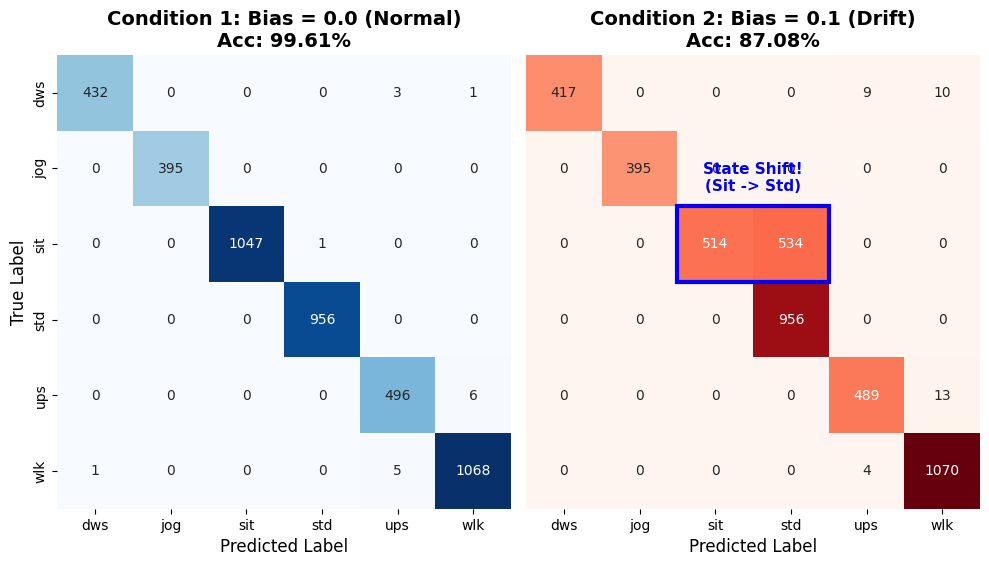

- MotionSense가 워낙 저노이즈 데이터셋이다 보니 Sitting과 Standing의 차이점이 오직 중력 가속도 벡터의 방향 (각도 차이)에 의해 결정되는 것.

- 정적 상태에서 가속도에 Drift를 추가하면 "기울기"가 변화하는 것이기 때문.


*Q. 왜 기울기가 변화하는 것으로 해석되는가?*\
*A. 가속도 센서의 벡터는 항상 원점에서 출발하는 화살표로 해석된다. 여기서 Drift는 곧 벡터의 평행이동을 말하고 이는 곧 원점에서 출발하는 화살표의 도착점이 달라지면서 원래의 각도가 변화하는 것으로 해석된다.(바닥면에 수직으로 쏘고 있는 레이저 포인터를 다른 곳으로 움직이는 것을 생각)*

---

1. MotionSense w/o contrast CM
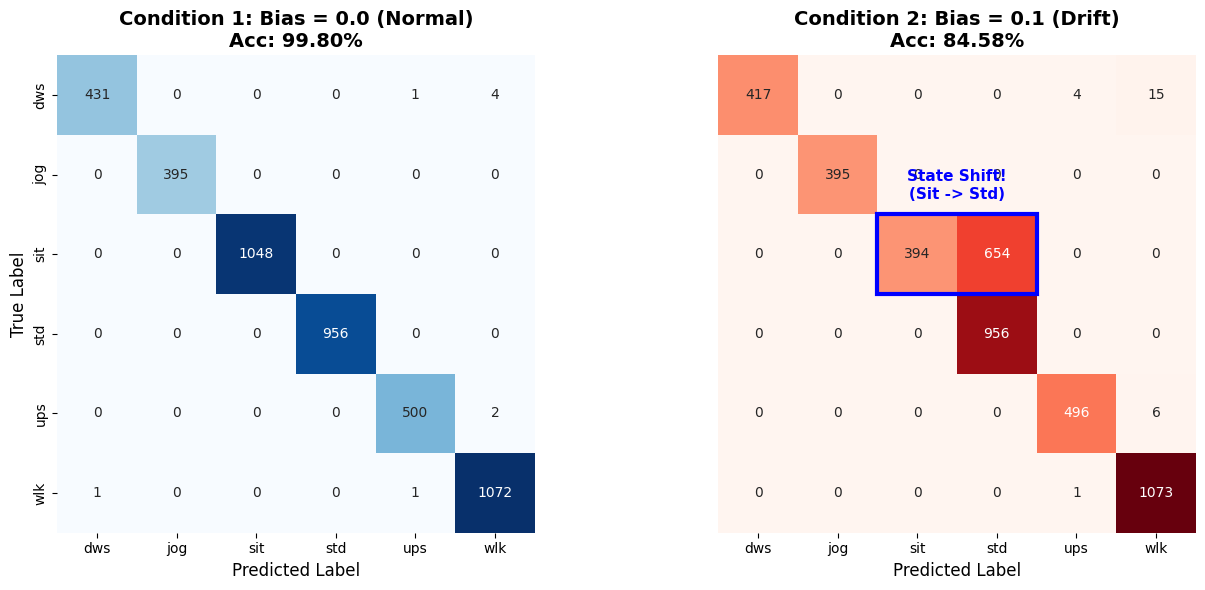

2. MotionSense Baseline CM
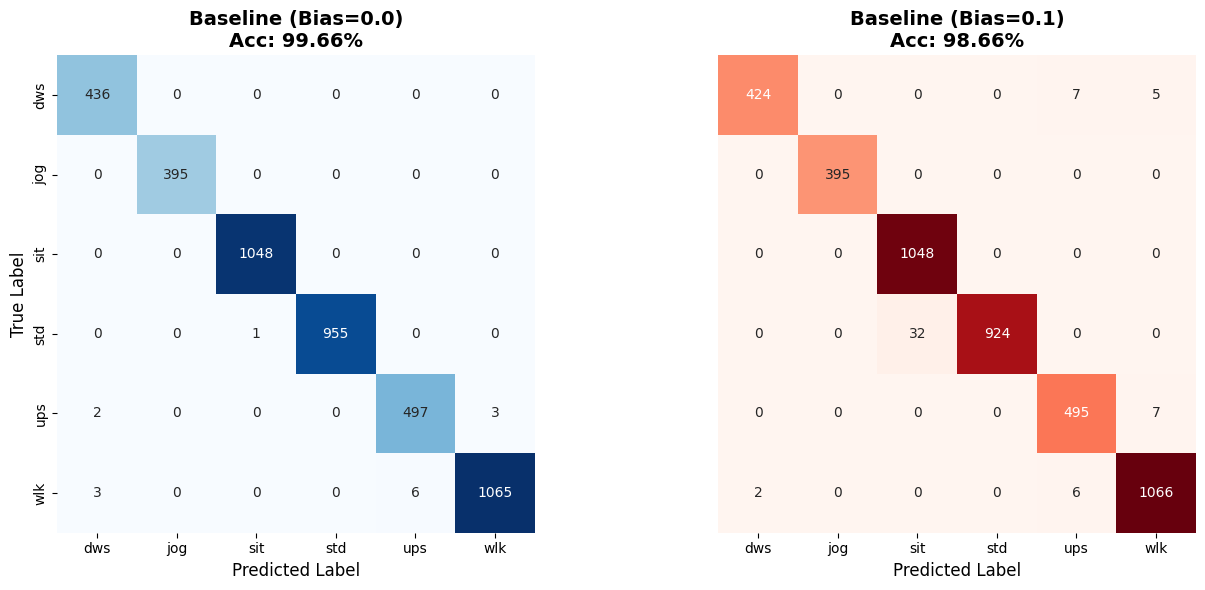

3. UCI-HAR CM
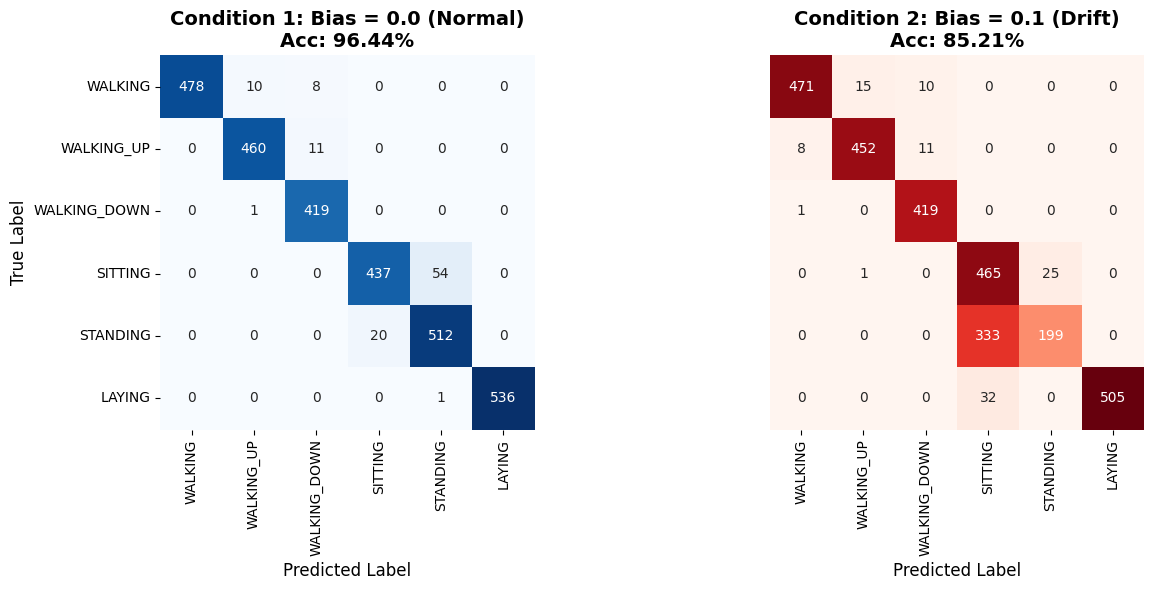

4. UCI-HAR w/o Contrast
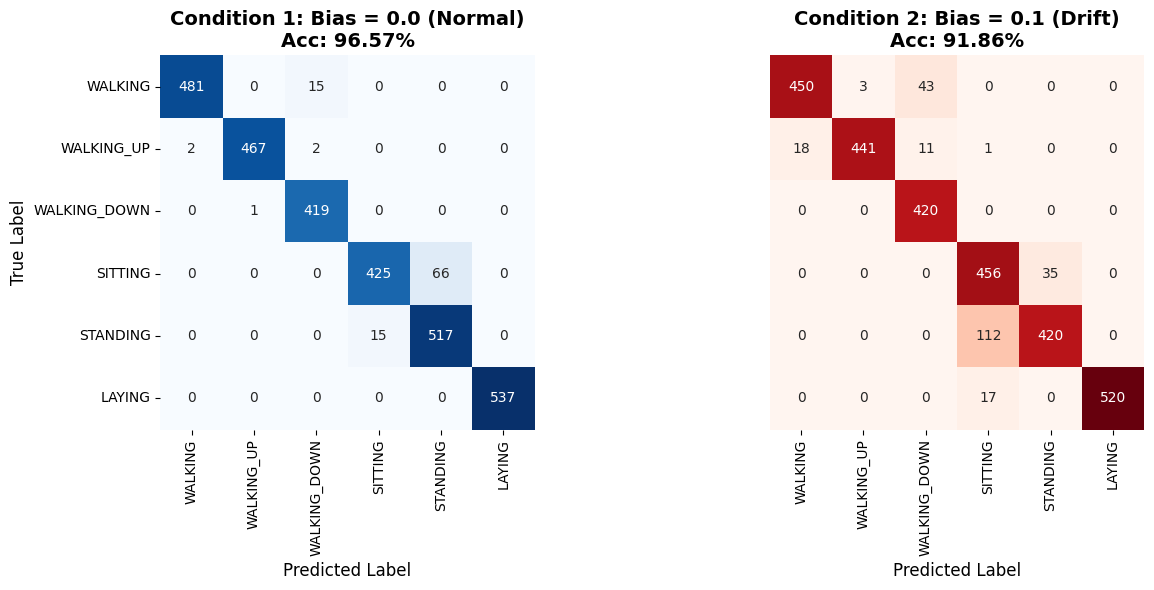

4. MHEALTH CM
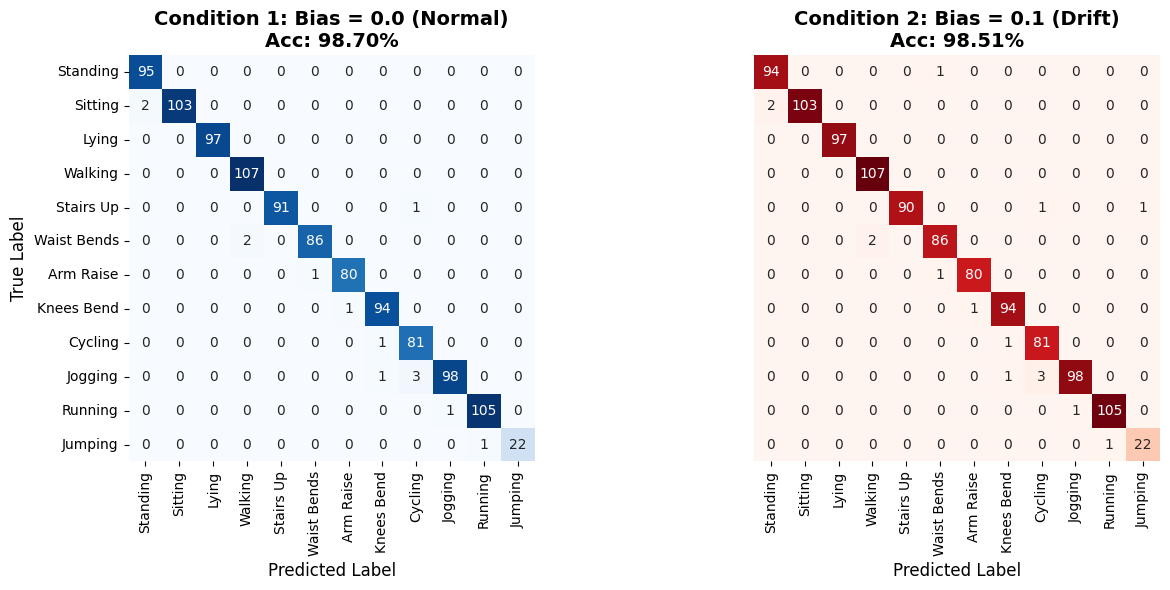

5. MHEALTH w/o Contrast CM
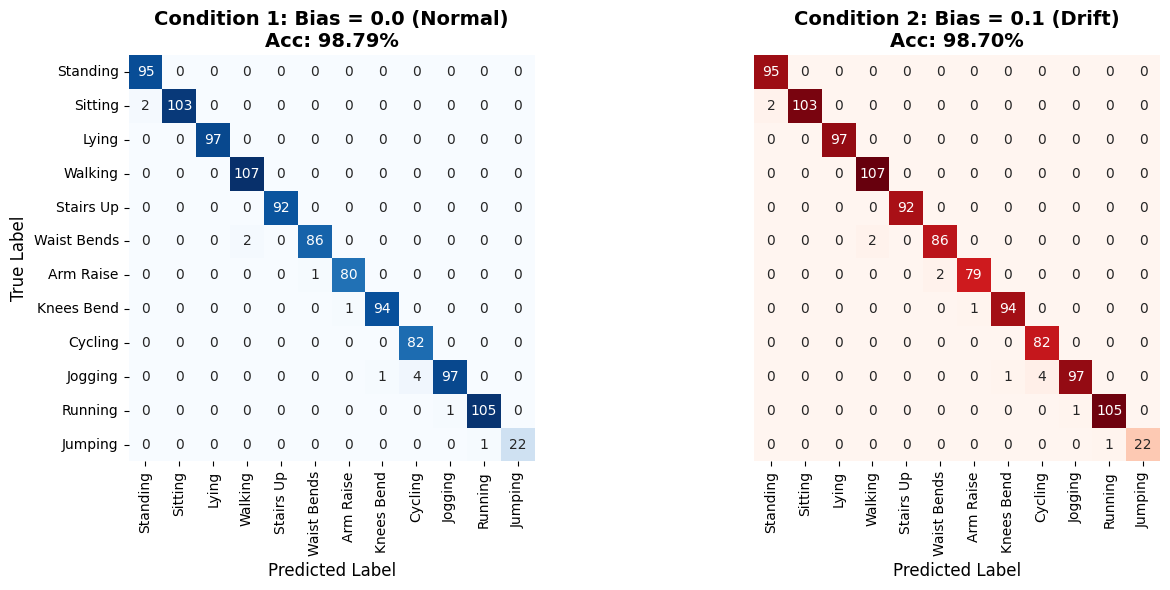

--------------------------------------------------------------------------------
ASF-DCL: Action State Flow with Dynamics-aware Contrastive Learning
--------------------------------------------------------------------------------
Batch size: 64
Epochs: 50
Learning rate: 0.001

Lambda_dyn: 0.05
Lambda_flow:  0.02
Lambda_proto: 0.05
Lambda_contrast: 0.0

[MotionSenseDataset] windows: 22053, classes: 6
Classes map: {'dws': 0, 'jog': 1, 'sit': 2, 'std': 3, 'ups': 4, 'wlk': 5}
Train size: 17642, Test size: 4411

Total parameters: 95,462

--------------------------------------------------------------------------------
TRAINING
--------------------------------------------------------------------------------
[25/50] Train Loss: 0.274 | F1: 0.9972  |  Test F1: 0.9911 (Best: 0.9943)
[50/50] Train Loss: 0.266 | F1: 1.0000  |  Test F1: 0.9971 (Best: 0.9976)

--------------------------------------------------------------------------------
EVALUATION...
----------------------------------------------

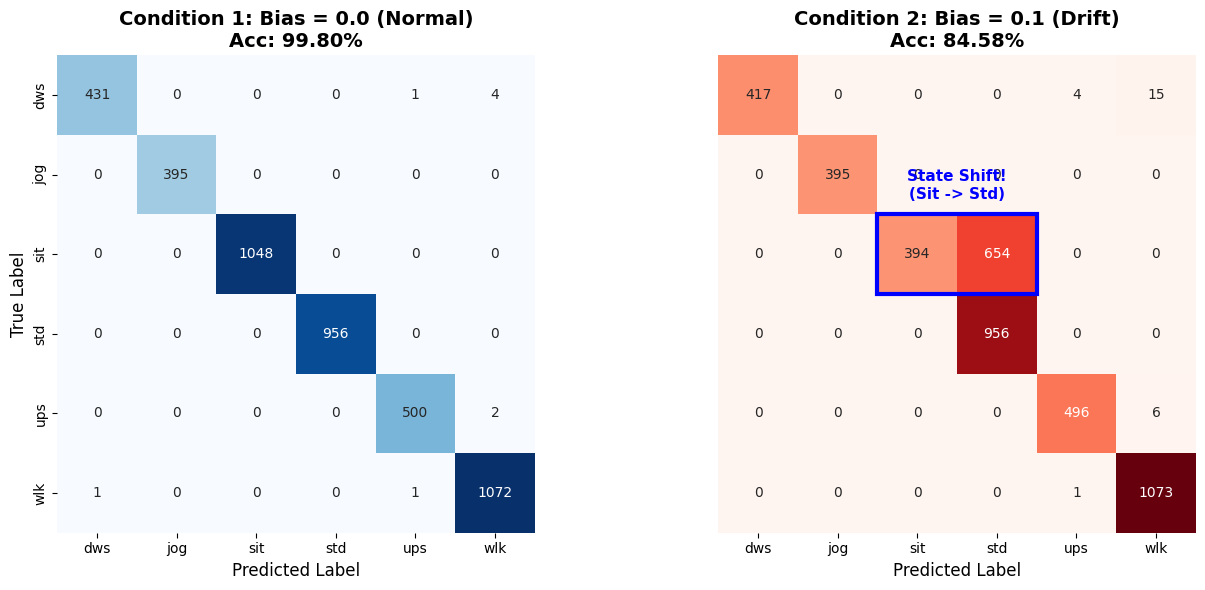

In [2]:
import os
import time
import copy
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ------------------------------------------------------------------------------
# 1. motion-sense Dataset
# ------------------------------------------------------------------------------
class MotionSenseDataset(Dataset):
    def __init__(
        self,
        root_dir,
        window_size=128,
        step_size=64,
        normalize=True,
        target_subjects=None,
        scaler=None
    ):
        self.root_dir = Path(root_dir)
        self.window_size = window_size
        self.step_size = step_size
        self.normalize = normalize

        self.data_dir = self.root_dir / "A_DeviceMotion_data"

        df_all = self._load_all_data()

        if target_subjects is not None:
            df_all = df_all[df_all['subject_id'].isin(target_subjects)].copy()
            print(f"Dataset initialized with subjects: {target_subjects}")
            print(f"Total rows after filtering: {len(df_all)}")

        activities = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']
        self.label2idx = {label: i for i, label in enumerate(activities)}
        self.idx2label = {i: label for label, i in self.label2idx.items()}
        df_all["label_idx"] = df_all["activity"].map(self.label2idx)

        feat_cols = [
            "userAcceleration.x", "userAcceleration.y", "userAcceleration.z",
            "rotationRate.x", "rotationRate.y", "rotationRate.z"
        ]
        feats = df_all[feat_cols].values.astype(np.float32)

        if self.normalize:
            if scaler is None:
                self.scaler = StandardScaler()
                feats = self.scaler.fit_transform(feats)
            else:
                self.scaler = scaler
                feats = self.scaler.transform(feats)
        else:
            self.scaler = None

        df_all[feat_cols] = feats

        X_list = []
        y_list = []

        for _, g in df_all.groupby(["subject_id", "activity", "trial_id"]):
            g = g.sort_values("timestamp_idx").reset_index(drop=True)

            data = g[feat_cols].values
            labels = g["label_idx"].values
            n = len(g)

            if n < window_size:
                continue

            for start in range(0, n - window_size + 1, step_size):
                end = start + window_size
                w_data = data[start:end]
                w_labels = labels[start:end]

                majority_label = np.bincount(w_labels).argmax()

                X_list.append(w_data.astype(np.float32))
                y_list.append(majority_label)

        self.X = np.stack(X_list) if len(X_list) > 0 else np.zeros((0, window_size, 6), dtype=np.float32)
        self.y = np.array(y_list, dtype=np.int64)

        print(f"[MotionSenseDataset] windows: {len(self.X)}, classes: {len(self.label2idx)}")
        print(f"Classes map: {self.label2idx}")

    def _load_all_data(self):
        all_dfs = []

        if not self.data_dir.exists():
             raise FileNotFoundError(f"Directory not found: {self.data_dir}")

        for folder in os.listdir(self.data_dir):
            folder_path = self.data_dir / folder
            if not folder_path.is_dir():
                continue

            parts = folder.split('_')
            activity_label = parts[0]
            subject_id = parts[1]

            for csv_file in os.listdir(folder_path):
                if not csv_file.endswith(".csv"):
                    continue

                file_path = folder_path / csv_file
                df = pd.read_csv(file_path)

                if "Unnamed: 0" in df.columns:
                    df = df.rename(columns={"Unnamed: 0": "timestamp_idx"})
                else:
                    df["timestamp_idx"] = range(len(df))

                df["activity"] = activity_label
                df["subject_id"] = int(subject_id)
                df["trial_id"] = folder

                all_dfs.append(df)

        return pd.concat(all_dfs, ignore_index=True)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.long)


# ------------------------------------------------------------------------------
# 2. ASF Model Components
# ------------------------------------------------------------------------------
class LatentEncoder(nn.Module):
    def __init__(self, input_channels=9, latent_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, latent_dim, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(latent_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        s = F.relu(self.bn3(self.conv3(h)))
        s = s.transpose(1, 2)
        return s

class FlowComputer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, s):
        B, T, D = s.shape

        flow_raw = s[:, 1:, :] - s[:, :-1, :]
        flow_mag = torch.norm(flow_raw, dim=-1, keepdim=True)
        flow_dir = flow_raw / (flow_mag + 1e-8)

        flow_features = torch.cat(
            [flow_raw, flow_mag.expand(-1, -1, D), flow_dir],
            dim=-1
        )
        return flow_features, flow_raw, flow_mag

class FlowEncoder(nn.Module):
    def __init__(self, flow_dim, hidden_dim=64, num_heads=4):
        super().__init__()
        self.flow_embed = nn.Linear(flow_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.flow_conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.flow_conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1, padding=0)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, flow_features):
        h = self.flow_embed(flow_features)
        h_att, _ = self.attention(h, h, h)

        h_att = h_att.transpose(1, 2)
        h = F.relu(self.bn1(self.flow_conv1(h_att)))
        h = F.relu(self.bn2(self.flow_conv2(h)))

        h_pool = torch.mean(h, dim=-1)
        return h_pool

class StateTransitionPredictor(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, s_t):
        B, Tm1, D = s_t.shape
        inp = s_t.reshape(B * Tm1, D)
        out = self.net(inp)
        return out.reshape(B, Tm1, D)

class ASFDCLClassifier(nn.Module):
    def __init__(self,
                 input_channels=9,
                 latent_dim=64,
                 hidden_dim=64,
                 num_classes=6,
                 num_heads=4,
                 projection_dim=128):
        super().__init__()

        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.latent_encoder = LatentEncoder(input_channels, latent_dim)
        self.flow_computer = FlowComputer()
        self.flow_encoder = FlowEncoder(latent_dim * 3, hidden_dim, num_heads)
        self.state_predictor = StateTransitionPredictor(latent_dim, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        self.flow_prototypes = nn.Parameter(
            torch.randn(num_classes, hidden_dim)
        )

        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )

    def forward(self, x, return_details=False):
        s = self.latent_encoder(x)

        s_t = s[:, :-1, :]
        s_next = s[:, 1:, :]
        s_pred_next = self.state_predictor(s_t)

        flow_features, flow_raw, flow_mag = self.flow_computer(s)

        h = self.flow_encoder(flow_features)

        z = self.projection_head(h)
        z = F.normalize(z, dim=-1)

        logits = self.classifier(h)

        if not return_details:
            return logits

        details = {
            "s": s,
            "s_t": s_t,
            "s_next": s_next,
            "s_pred_next": s_pred_next,
            "flow_features": flow_features,
            "flow_raw": flow_raw,
            "flow_mag": flow_mag,
            "h": h,
            "z": z,
            "prototypes": self.flow_prototypes
        }
        return logits, details


# ------------------------------------------------------------------------------
# 3. Dynamics-aware Contrastive Loss
# ------------------------------------------------------------------------------
def compute_contrastive_loss(z, labels, temperature=0.07):
    B = z.shape[0]
    device = z.device

    sim_matrix = torch.mm(z, z.t()) / temperature

    labels_expanded = labels.unsqueeze(1)
    positive_mask = (labels_expanded == labels_expanded.t()).float()

    positive_mask = positive_mask - torch.eye(B, device=device)

    mask = torch.eye(B, device=device).bool()
    sim_matrix_masked = sim_matrix.masked_fill(mask, float('-inf'))

    exp_sim = torch.exp(sim_matrix_masked)

    pos_sim = (exp_sim * positive_mask).sum(dim=1)

    all_sim = exp_sim.sum(dim=1)

    has_positive = positive_mask.sum(dim=1) > 0

    if has_positive.sum() == 0:
        return torch.tensor(0.0, device=device)

    loss = -torch.log(pos_sim[has_positive] / (all_sim[has_positive] + 1e-8))

    return loss.mean()


# ------------------------------------------------------------------------------
# 4. ASF-DCL Losses: CE + L_dyn + L_flow_prior + L_proto + L_contrast
# ------------------------------------------------------------------------------
def compute_asf_dcl_losses(logits, details, labels,
                           lambda_dyn=0.1,
                           lambda_flow=0.05,
                           lambda_proto=0.1,
                           lambda_contrast=0.15,
                           dyn_classes=(0, 1, 4, 5),
                           static_classes=(2, 3),
                           dyn_target=0.7,
                           static_target=0.1,
                           proto_tau=0.1,
                           contrast_temp=0.07):
    device = logits.device

    cls_loss = F.cross_entropy(logits, labels, label_smoothing=0.05)

    s_next = details["s_next"]
    s_pred_next = details["s_pred_next"]
    dyn_loss = F.mse_loss(s_pred_next, s_next)

    flow_mag = details["flow_mag"]
    B, Tm1, _ = flow_mag.shape
    flow_mean = flow_mag.mean(dim=1).view(B)

    dyn_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    static_mask = torch.zeros_like(flow_mean, dtype=torch.bool)
    for c in dyn_classes:
        dyn_mask = dyn_mask | (labels == c)
    for c in static_classes:
        static_mask = static_mask | (labels == c)

    flow_prior_loss = torch.tensor(0.0, device=device)
    if dyn_mask.any():
        dyn_flow = flow_mean[dyn_mask]
        flow_prior_loss = flow_prior_loss + F.mse_loss(
            dyn_flow, torch.full_like(dyn_flow, dyn_target)
        )
    if static_mask.any():
        static_flow = flow_mean[static_mask]
        flow_prior_loss = flow_prior_loss + F.mse_loss(
            static_flow, torch.full_like(static_flow, static_target)
        )

    h = details["h"]
    prototypes = details["prototypes"]

    h_norm = F.normalize(h, dim=-1)
    proto_norm = F.normalize(prototypes, dim=-1)

    sim = h_norm @ proto_norm.t()
    proto_logits = sim / proto_tau
    proto_loss = F.cross_entropy(proto_logits, labels, label_smoothing=0.05)

    z = details["z"]
    contrast_loss = compute_contrastive_loss(z, labels, temperature=contrast_temp)

    total_loss = (
        cls_loss +
        lambda_dyn * dyn_loss +
        lambda_flow * flow_prior_loss +
        lambda_proto * proto_loss +
        lambda_contrast * contrast_loss
    )

    loss_dict = {
        "total": total_loss.item(),
        "cls": cls_loss.item(),
        "dyn": dyn_loss.item(),
        "flow_prior": flow_prior_loss.item(),
        "proto": proto_loss.item(),
        "contrast": contrast_loss.item()
    }
    return total_loss, loss_dict


# ------------------------------------------------------------------------------
# 5. Train / Evaluation
# ------------------------------------------------------------------------------
def train_epoch(model, dataloader, optimizer, device,
                lambda_dyn=0.1, lambda_flow=0.05,
                lambda_proto=0.1, lambda_contrast=0.15):
    model.train()
    total_loss = 0

    all_preds = []
    all_labels = []

    loss_accumulator = {
        "cls": 0.0,
        "dyn": 0.0,
        "flow_prior": 0.0,
        "proto": 0.0,
        "contrast": 0.0
    }

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        logits, details = model(x, return_details=True)
        loss, loss_dict = compute_asf_dcl_losses(
            logits, details, y,
            lambda_dyn=lambda_dyn,
            lambda_flow=lambda_flow,
            lambda_proto=lambda_proto,
            lambda_contrast=lambda_contrast
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for k in loss_accumulator.keys():
            loss_accumulator[k] += loss_dict[k]

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    for k in loss_accumulator.keys():
        loss_accumulator[k] /= len(dataloader)

    return avg_loss, acc, f1, loss_accumulator

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return avg_loss, acc, f1, cm

def evaluate_with_bias(model, dataloader, device, bias):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            if bias != 0:
                x = x + bias

            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(y.detach().cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, f1

def analyze_mechanism(model, dataloader, device, bias, static_indices=[2, 3]):
    model.eval()
    all_preds = []
    all_labels = []

    static_flows = []
    dynamic_flows = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            if bias != 0:
                x = x + bias

            logits, details = model(x, return_details=True)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            avg_flow_per_sample = details['flow_mag'].mean(dim=1).mean(dim=1).cpu().numpy()

            y_np = y.cpu().numpy()
            for i in range(len(y_np)):
                label = y_np[i]
                flow_val = avg_flow_per_sample[i]

                if label in static_indices:
                    static_flows.append(flow_val)
                else:
                    dynamic_flows.append(flow_val)

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    avg_static_flow = np.mean(static_flows) if len(static_flows) > 0 else 0.0
    avg_dynamic_flow = np.mean(dynamic_flows) if len(dynamic_flows) > 0 else 0.0

    return acc, cm, avg_static_flow, avg_dynamic_flow


# ------------------------------------------------------------------------------
# 6. Main Training Loop
# ------------------------------------------------------------------------------
def main():
    SEED = 42
    set_seed(SEED)

    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/HAR_data/motion-sense'
    BATCH_SIZE = 64
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    LAMBDA_DYN = 0.05
    LAMBDA_FLOW = 0.02
    LAMBDA_PROTO = 0.05
    LAMBDA_CONTRAST = 0.0

    print("-"*80)
    print("ASF-DCL: Action State Flow with Dynamics-aware Contrastive Learning")
    print("-"*80)
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {NUM_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print()
    print(f"Lambda_dyn: {LAMBDA_DYN}")
    print(f"Lambda_flow:  {LAMBDA_FLOW}")
    print(f"Lambda_proto: {LAMBDA_PROTO}")
    print(f"Lambda_contrast: {LAMBDA_CONTRAST}")
    print()

    full_dataset = MotionSenseDataset(DATA_PATH, window_size=128, step_size=64, target_subjects=None, normalize=False)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    g_split = torch.Generator().manual_seed(SEED)
    train_subset, test_subset = random_split(full_dataset, [train_size, test_size], generator=g_split)
    print(f"Train size: {len(train_subset)}, Test size: {len(test_subset)}")

    train_indices = train_subset.indices
    train_data = full_dataset.X[train_indices]

    N, T, C = train_data.shape
    scaler = StandardScaler()
    scaler.fit(train_data.reshape(-1, C))

    full_N, full_T, full_C = full_dataset.X.shape
    full_scaled = scaler.transform(full_dataset.X.reshape(-1, full_C))
    full_dataset.X = full_scaled.reshape(full_N, full_T, full_C)

    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2,
                              worker_init_fn=seed_worker,
                              generator=g)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2,
                             worker_init_fn=seed_worker,
                             generator=g)

    model = ASFDCLClassifier(
        input_channels=6,
        latent_dim=64,
        hidden_dim=64,
        num_classes=6,
        num_heads=4,
        projection_dim=128
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print()
    print(f"Total parameters: {total_params:,}")

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE,
                                 weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=NUM_EPOCHS
    )

    best_acc = 0.0
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    print("\n" + "-"*80)
    print("TRAINING")
    print("-"*80)

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_f1, loss_dict = train_epoch(
            model, train_loader, optimizer, DEVICE,
            lambda_dyn=LAMBDA_DYN,
            lambda_flow=LAMBDA_FLOW,
            lambda_proto=LAMBDA_PROTO,
            lambda_contrast=LAMBDA_CONTRAST
        )

        test_loss, test_acc, test_f1, test_cm = evaluate(
            model, test_loader, DEVICE
        )

        scheduler.step()

        if test_f1 > best_f1:
            best_f1 = test_f1
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time = time.time() - start_time
        best_acc = max(best_acc, test_acc)
        best_f1 = max(best_f1, test_f1)

        if (epoch + 1) % 25 == 0 or (epoch + 1) == NUM_EPOCHS:
            log_msg = (f"[{epoch+1:02d}/{NUM_EPOCHS}] "
                    f"Train Loss: {train_loss:.3f} | F1: {train_f1:.4f}  |  "
                    f"Test F1: {test_f1:.4f} (Best: {best_f1:.4f})")
            print(log_msg)

    print("\n" + "-"*80)
    print("EVALUATION...")
    print("-"*80)

    test_loss, test_acc, test_f1, test_cm = evaluate(
        model, test_loader, DEVICE
    )
    print(f"Final Result → Best Test F1: {best_f1:.4f} (Acc: {best_acc:.4f})")

    print("\n" + "-"*80)
    print(" HYPOTHESIS VERIFICATION EXPERIMENTS")
    print("-"*80)

    model.load_state_dict(best_model_wts)

    static_idxs = [2, 3]
    activities = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

    acc_0, cm_0, static_flow_0, dynamic_flow_0 = analyze_mechanism(
        model, test_loader, DEVICE, bias=0.0, static_indices=static_idxs
    )

    acc_bias, cm_bias, static_flow_bias, dynamic_flow_bias = analyze_mechanism(
        model, test_loader, DEVICE, bias=0.1, static_indices=static_idxs
    )

    print(f"\n[Experiment 1] Flow Magnitude Analysis (Sensitivity Check)")
    print("-" * 60)
    print(f"{'Condition':<15} | {'Avg Flow (Static)':<20} | {'Avg Flow (Dynamic)':<20}")
    print("-" * 60)
    print(f"{'Bias 0.0':<15} | {static_flow_0:.6f}{'':<12} | {dynamic_flow_0:.6f}")
    print(f"{'Bias 0.1':<15} | {static_flow_bias:.6f} (+{static_flow_bias-static_flow_0:.4f})  | {dynamic_flow_bias:.6f}")
    print("-" * 60)

    print(f"\n[Experiment 2] Confusion Matrix Visualization")
    print("-" * 60)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_0, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                square=True, cbar=False,
                xticklabels=activities, yticklabels=activities)

    axes[0].set_title(f'Condition 1: Bias = 0.0 (Normal)\nAcc: {acc_0*100:.2f}%', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    sns.heatmap(cm_bias, annot=True, fmt='d', cmap='Reds', ax=axes[1],
                square=True, cbar=False,
                xticklabels=activities, yticklabels=activities)

    axes[1].set_title(f'Condition 2: Bias = 0.1 (Drift)\nAcc: {acc_bias*100:.2f}%', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_yticks([])

    rect = patches.Rectangle((2, 2), 2, 1, linewidth=3, edgecolor='blue', facecolor='none')
    axes[1].add_patch(rect)
    axes[1].text(3, 1.8, 'State Shift!\n(Sit -> Std)', color='blue', fontsize=11, fontweight='bold', ha='center')

    plt.tight_layout()
    plt.show()

    return model

if __name__ == "__main__":
    main()